# **Creating a Scorecard with `OptBinning` **


In [1]:
import pandas as pd
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

(CVXPY) Jul 18 12:36:53 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 18 12:36:53 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## 1. Loading dataset
The dataset used in this tutorial is available at Kaggle and was part of the "Home Credit Default Risk" Challenge.
- https://www.kaggle.com/c/home-credit-default-risk/data


### 1.1. Table Application Train
The data available for the challenge is distributed throughout 8 CSV files:

* application_train.csv
* previous_application.csv
* credit_card_balance.csv
* POS_CASH_balance.csv
* installments_payments.csv
* bureau_balance.csv
* bureau.csv

Also available is the description for each column in tables (`HomeCredit_columns_description.csv`), and the application test and submission tables (`application_test.csv` and `sample_submission.csv`).

In order to make the tutorial as accessible as possible we are going to only use the `application_train.csv` file to develop the Scorecard.

In [2]:
df_application = pd.read_csv('/Users/mengjiatan/Desktop/application_train.csv', low_memory=True)
df_application.set_index('SK_ID_CURR', inplace=True)
df_application.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_application.shape
X = df_application.drop('TARGET', axis=1)
y = df_application["TARGET"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train.shape

(246008, 120)

### 1.2. Checking categorical features
`Optbinning` needs the information whether the features are numerical or categorical.
So we are going to verify the dtypes of each column to make sure it's correct. 

In [6]:
X_train.dtypes.value_counts()

float64    65
int64      39
object     16
Name: count, dtype: int64

In [7]:
X_train.select_dtypes(include='object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
SK_ID_CURR,,,,,,,,,,,,,,,,
243191,Cash loans,F,Y,N,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,TUESDAY,XNA,NaN,NaN,NaN,NaN
111778,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Business Entity Type 2,reg oper account,block of flats,"Stone, brick",No
175057,Cash loans,M,Y,Y,Unaccompanied,Working,Lower secondary,Civil marriage,House / apartment,Drivers,FRIDAY,Self-employed,NaN,NaN,NaN,NaN
372147,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,High skill tech staff,TUESDAY,Trade: type 3,reg oper account,terraced house,Panel,No
373412,Cash loans,M,N,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Industry: type 11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Cooking staff,MONDAY,Self-employed,NaN,NaN,NaN,NaN
399937,Cash loans,F,N,N,"Spouse, partner",Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,TUESDAY,Trade: type 7,NaN,NaN,NaN,NaN
253016,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,Single / not married,House / apartment,Managers,MONDAY,Self-employed,reg oper account,block of flats,Panel,No


## 2. Creating the `BinningProcess` instance
The `Scorecard` need an instance of `BinningProcess` with the corresponding data for the dataset and also an `sklearn.linear_model`. <br>
We can also provide a `selection_criteria` for the selection of features.

In [8]:
list_features = X_train.columns.values
list_categorical = X_train.select_dtypes(include=['object', 'category']).columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [9]:
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

In [33]:
df_train_binned = binning_process.fit_transform(X_train.values, y_train)

In [34]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
243191,Cash loans,F,Y,N,0,171000.0,555273.0,16366.5,463500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
111778,Cash loans,M,N,Y,1,157500.0,198085.5,23638.5,171000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
175057,Cash loans,M,Y,Y,0,135000.0,776304.0,25173.0,648000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
372147,Cash loans,M,Y,Y,1,164133.0,900000.0,36787.5,900000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
373412,Cash loans,M,N,Y,0,225000.0,533668.5,21294.0,477000.0,"Spouse, partner",...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
399937,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
253016,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0


In [35]:
df_train_binned.shape[1]

85

## 3. Defining the Linear Estimator
`Scorecard` accepts any Linear Estimator from Scikit-Learn. 

In [10]:
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

## 4. Creating a Scorecard
To instantiate the `Scorecard` class you need to pass as parameters the `binning_process` and linear model (`log_reg`), 

In [11]:
%%time
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 1000}
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True,
)

scorecard.fit(X_train,y_train)

CPU times: user 42.4 s, sys: 2.65 s, total: 45.1 s
Wall time: 19.3 s


Scorecard(binning_process=BinningProcess(categorical_variables=array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSM...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})

## 5. Visualizing Scorecard
To access the Scorecard table with metrics and points for each feature and bin you simply run the method `table` for your `Scorecard` fitted instance.

### 5.1. Saving the Scorecard table

In [12]:
scorecard_summary = scorecard.table(style="detailed").round(3)
#scorecard_summary.to_csv('scorecard_table_detailed.csv', index=False)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,NAME_CONTRACT_TYPE,0,[Revolving loans],23518,0.096,22243,1275,0.054,0.427,0.015,0.002,-0.637,-8.416
1,NAME_CONTRACT_TYPE,1,[Cash loans],222490,0.904,203889,18601,0.084,-0.037,0.001,0.000,-0.637,6.996
2,NAME_CONTRACT_TYPE,2,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.637,5.761
3,NAME_CONTRACT_TYPE,3,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.637,5.761
0,CODE_GENDER,0,"[XNA, F]",161858,0.658,150524,11334,0.070,0.155,0.015,0.002,-0.708,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,AMT_REQ_CREDIT_BUREAU_YEAR,2,"[1.50, 3.50)",67066,0.273,61690,5376,0.080,0.009,0.000,0.000,-0.378,5.592
3,AMT_REQ_CREDIT_BUREAU_YEAR,3,"[3.50, 4.50)",16600,0.067,15243,1357,0.082,-0.013,0.000,0.000,-0.378,6.012
4,AMT_REQ_CREDIT_BUREAU_YEAR,4,"[4.50, inf)",21011,0.085,19160,1851,0.088,-0.095,0.001,0.000,-0.378,7.620
5,AMT_REQ_CREDIT_BUREAU_YEAR,5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.378,5.761


### 5.2. Visualizing Scorecard performance

In [20]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc
from sklearn.metrics import roc_auc_score

In [23]:
#X_test.loc[:,"predict_proba"] = scorecard.predict_proba(X_test)[:, 1]
#X_test.loc[:,"score"] = scorecard.score(X_test)

y_pred_proba = scorecard.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC score:', roc_auc)

ROC-AUC score: 0.7469044100588101


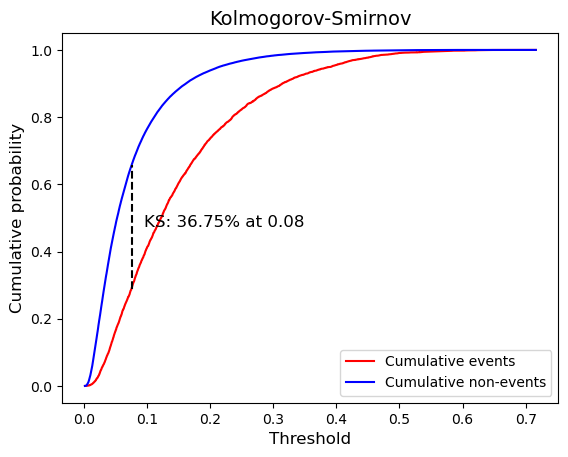

In [25]:
plot_ks(y_test, y_pred_proba)

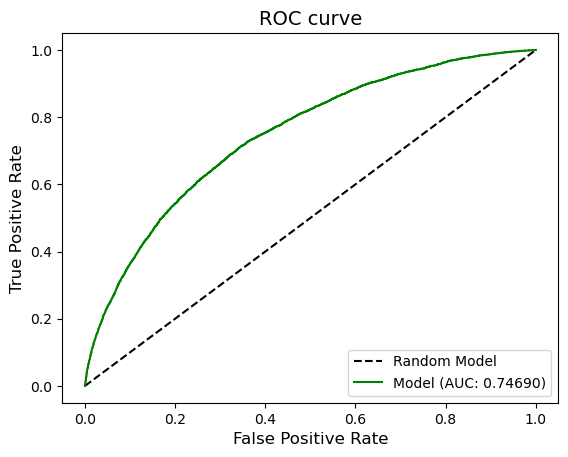

In [24]:
plot_auc_roc(y_test, y_pred_proba)

## 6. Saving the Scorecard as pickle and using it for prediction
`Scorecard` objects can easily be pickled and saved for further usage or put into production.


### 6.1. Pickling Scorecard

In [26]:
import pickle

with open('scorecard_model.pickle', 'wb') as pfile:
   pickle.dump(scorecard, pfile)

### 6.2. Unpickling Scorecard

In [27]:
with open("scorecard_model.pickle", 'rb') as scorecard_pickle:
    scorecard_production = pickle.load(scorecard_pickle)
print(scorecard_production)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSM...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})


### 6.3. Performing predictions in production

In [28]:
# For a few samples
scorecard_production.score(X_test.iloc[0:100, :])

array([570.68023797, 434.63307242, 536.28940191, 418.97954941,
       502.66967298, 563.34800993, 501.91089004, 556.73938174,
       522.40354961, 495.90803749, 519.31183022, 567.67656518,
       504.48325622, 503.36107137, 541.28729076, 567.08611229,
       352.73616439, 567.24236214, 509.96764732, 450.98189226,
       502.16138866, 492.58477102, 536.34475885, 552.86944674,
       534.950001  , 523.11823844, 504.25882779, 503.48637879,
       563.28772349, 414.50422348, 517.84484894, 472.64811431,
       497.57104759, 430.90356277, 550.2788857 , 442.53598025,
       517.37520263, 516.86273533, 468.66683054, 415.88411824,
       440.50483692, 419.53828504, 551.56389927, 587.99345183,
       430.97399089, 461.85965162, 472.49032469, 431.55950424,
       431.83407989, 497.39777792, 524.00405913, 489.55145258,
       545.08912012, 522.7926539 , 529.21711492, 546.90202786,
       498.20357769, 613.31138591, 437.54604981, 499.84082508,
       526.29557714, 540.86574437, 449.19562817, 479.97

In [30]:
score = scorecard_production.score(X_test)

In [31]:
max(score),min(score)

(684.0670897376312, 312.2379470600034)

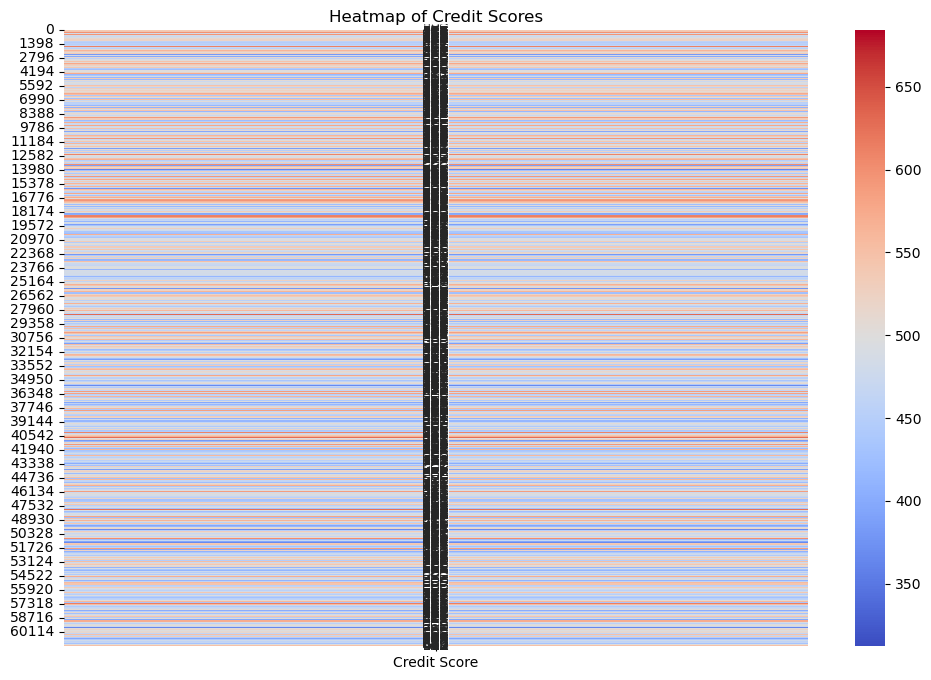

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the credit scores
df_scores = pd.DataFrame(score, columns=['Credit Score'])

# Create a heatmap of the credit scores
plt.figure(figsize=(12, 8))
sns.heatmap(df_scores, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Heatmap of Credit Scores')
plt.show()